In [1]:
import sys, os
import torch
from torch import Tensor
from torch.utils.data import DataLoader, random_split
from trajdata import AgentBatch, UnifiedDataset

sys.path.append(os.path.abspath("../"))
from src.data.batch_proccessing import make_model_collate
from src.models.ode_baseline import ODEBaseline
from torch import nn
from tqdm import tqdm
import pytorch_lightning as pl
import matplotlib.pyplot as plt
pl.seed_everything(42)

/home/g.devchich/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/lightning_utilities/core/imports.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Global seed set to 42


42

In [2]:
dataset = UnifiedDataset(
        desired_data=["eupeds_eth","eupeds_hotel","eupeds_univ","eupeds_zara1","eupeds_zara2"],
        data_dirs={
            "eupeds_eth":  "../data/eth",
            "eupeds_hotel":"../data/eth",
            "eupeds_univ": "../data/eth",
            "eupeds_zara1":"../data/eth",
            "eupeds_zara2":"../data/eth",
        },
        desired_dt=0.1,
        state_format='x,y',
        obs_format='x,y',
        centric="scene",
        history_sec=(0.8,0.8),
        future_sec=(0.8,0.8),
        standardize_data=False,
    )
collate_fn = make_model_collate(dataset=dataset, memory=4, dim=2)

In [3]:
@torch.no_grad()
def ade_fde(pred, gt):  # pred, gt: (F,N,2)
    d = torch.linalg.norm(pred - gt, dim=-1)  # (F,N)
    return d.mean().item(), d[-1].mean().item()

In [4]:
N = len(dataset)
n_eval = max(1, int(0.05 * N))
_, eval_ds = random_split(dataset, [N - n_eval, n_eval], generator=torch.Generator().manual_seed(42))

eval_loader = DataLoader(eval_ds, batch_size=64, shuffle=False,
                             num_workers=0, pin_memory=True,
                             collate_fn=collate_fn)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = ODEBaseline(dim=2, w=512).to(device)
# model.load_state_dict(torch.load("ode_baseline.pth", map_location=device))
model.eval()

ODEBaseline(
  (func): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): SiLU()
      (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): SiLU()
      (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (6): Linear(in_features=512, out_features=2, bias=True)
    )
  )
)

In [7]:
sum_ade, sum_fde, batches = 0.0, 0.0, 0
with torch.no_grad():
        for batch in tqdm(eval_loader):
            if batch is None: 
                continue
            x0, x0_class, x1_full, x1_next, t0, t1 = batch
            x0,x1_full, x1_next, t1 = x0.to(device),x1_full.to(device) ,x1_next.to(device), t1.to(device)
            dt = t1[0].item()        # одинаковое dt в батче
            pred = model.predict_autoreg(x0, dt=dt, F=8).to(device)  # (F,N,2)

            # ground truth: первые 8 точек будущего из датасета (предполагается в x1)
            # если нужен полный future, добавь в collate
                 # временный костыль
            ade, fde = ade_fde(pred, x1_full)
            sum_ade += ade
            sum_fde += fde
            batches += 1

if batches == 0:
        print("Нет валидных батчей.")
else:
        print(f"ADE (20%): {sum_ade/batches:.6f}   FDE (20%): {sum_fde/batches:.6f}")

100%|██████████| 436/436 [08:39<00:00,  1.19s/it]

ADE (20%): 0.382826   FDE (20%): 0.576057


In [8]:
@torch.no_grad()
def plot_gt_vs_pred_from_batch(model, batch, rows=4, cols=4, shared_limits=True,
                               seed=0xDEADBEEF, rtol=1e-5, atol=1e-7,
                               min_span=0.5, pad_ratio=0.15):
    x0, x0_class, x1_full, x1_next, t0, t1 = batch
    device = next(model.parameters()).device
    x0, x0_class, x1_full, t1 = x0.to(device), x0_class.to(device), x1_full.to(device), t1.to(device)

    N, D = x0.shape
    M = x0_class.size(1) // 2
    F = x1_full.size(1)
    dt = t1[0].to(x0.dtype).item()

    pred = model.predict_autoreg(x0, dt=dt, F=F, rtol=rtol, atol=atol)  # (F,N,2)

    # === всё на CPU один раз ===
    x0_cpu        = x0.detach().cpu()
    x0_class_cpu  = x0_class.detach().cpu()
    gt_NF2        = x1_full.detach().cpu()                  # (N,F,2)
    pred_NF2      = pred.detach().cpu()      # (N,F,2)

    K = min(rows*cols, N)
    g = torch.Generator().manual_seed(seed)
    idxs = torch.randperm(N, generator=g)[:K].tolist()

    global_xlim = global_ylim = None
    if shared_limits:
        all_pts = []
        for i in idxs:
            hist = x0_class_cpu[i].reshape(M,2)
            parts = [hist, x0_cpu[i:i+1], gt_NF2[i], pred_NF2[i]]
            all_pts.append(torch.vstack(parts))
        pts = torch.vstack(all_pts)
        x_min, y_min = pts.min(dim=0).values.tolist()
        x_max, y_max = pts.max(dim=0).values.tolist()
        span = max(x_max - x_min, y_max - y_min, min_span) * (1.0 + pad_ratio)
        cx, cy = (x_min + x_max)/2.0, (y_min + y_max)/2.0
        global_xlim = (cx - span/2, cx + span/2)
        global_ylim = (cy - span/2, cy + span/2)

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for ax, i in zip(axes, idxs):
        hist = x0_class_cpu[i].reshape(M,2)
        x0_i = x0_cpu[i]
        gt_i = gt_NF2[i]
        pr_i = pred_NF2[i]

        if M > 0: ax.plot(hist[:,0], hist[:,1], marker='o', linestyle='-', linewidth=1, label='history')
        ax.scatter(x0_i[0].item(), x0_i[1].item(), s=30, label='x0')
        ax.plot(gt_i[:,0], gt_i[:,1], linestyle='--', linewidth=1.5, label='GT')
        ax.plot(pr_i[:,0], pr_i[:,1], linestyle='-',  linewidth=1.8, label='Pred')

        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"id={i}", fontsize=9)
        ax.grid(True); ax.set_xlabel("x", fontsize=8); ax.set_ylabel("y", fontsize=8)

        if global_xlim is not None:
            ax.set_xlim(*global_xlim); ax.set_ylim(*global_ylim)
        else:
            pts = torch.vstack([hist, x0_i.unsqueeze(0), gt_i, pr_i])
            xmin, ymin = pts.min(dim=0).values.tolist()
            xmax, ymax = pts.max(dim=0).values.tolist()
            span = max(xmax - xmin, ymax - ymin, min_span) * (1.0 + pad_ratio)
            cx, cy = (xmin + xmax)/2.0, (ymin + ymax)/2.0
            ax.set_xlim(cx - span/2, cx + span/2)
            ax.set_ylim(cy - span/2, cy + span/2)

    for j in range(K, rows*cols): fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    if handles: fig.legend(handles, labels, loc='upper right', fontsize=9)
    fig.suptitle(f"{rows}×{cols} GT vs Pred (F={F}, dt={dt:.2f})", fontsize=14)
    fig.tight_layout()
    plt.show()

In [12]:
batch = next(iter)

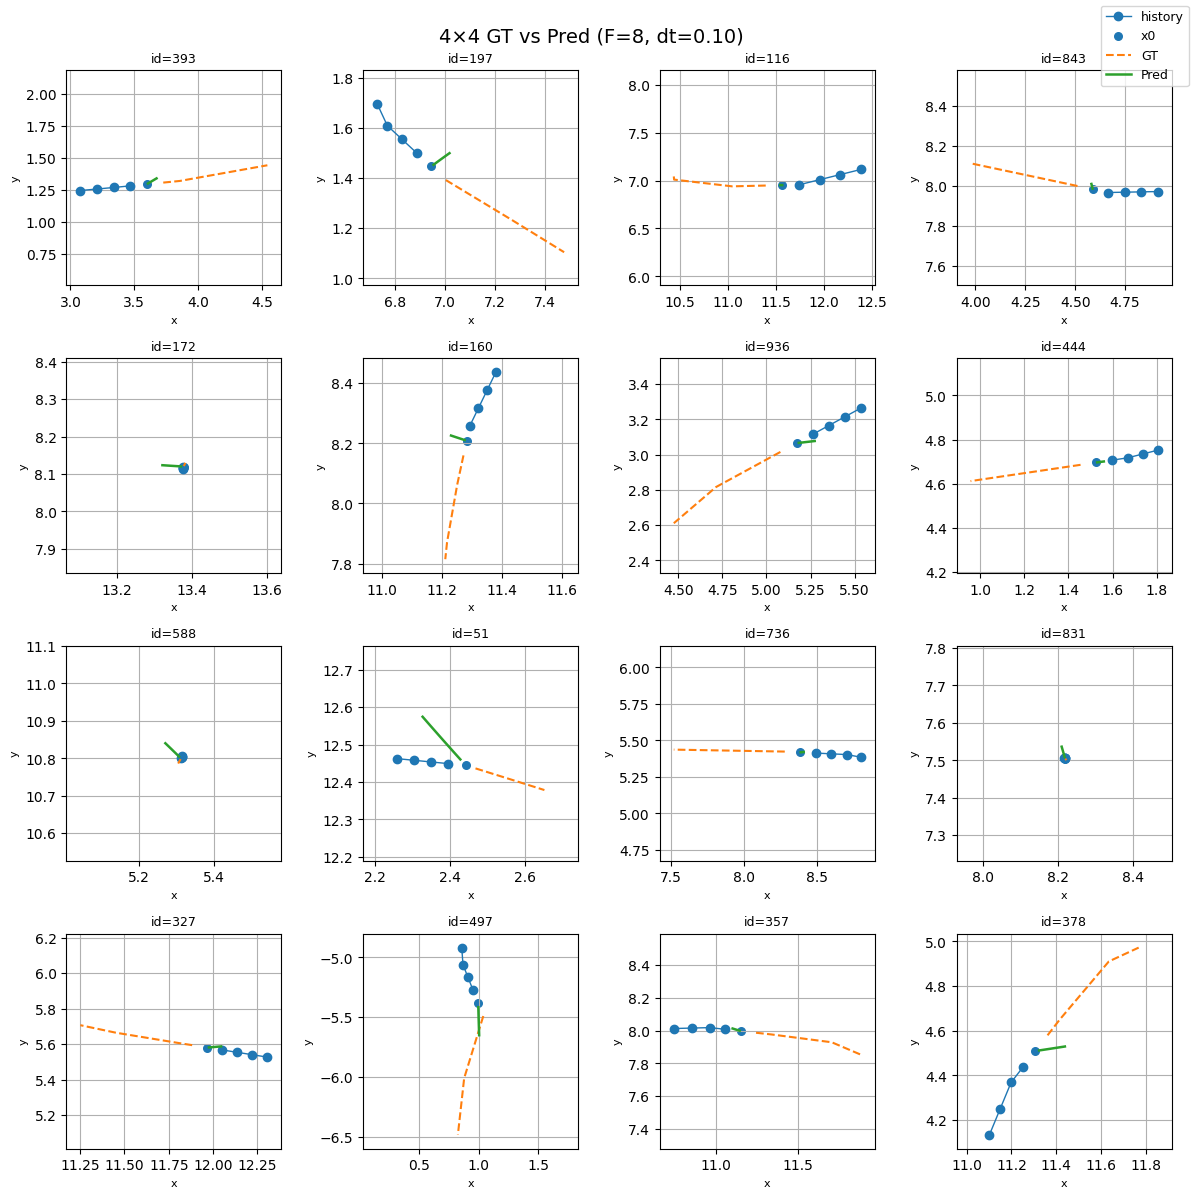

In [13]:
_ = plot_gt_vs_pred_from_batch(model, batch, rows=4, cols=4, shared_limits=False)

In [7]:
sum_ade, sum_fde, batches = 0.0, 0.0, 0
with torch.no_grad():
    for batch in tqdm(eval_loader):
        if batch is None: continue
        x0, x0_class, x1_full, x1_next, t0, t1 = batch
        x0, x1_full, t1 = x0.to(device), x1_full.to(device), t1.to(device)

        F = x1_full.size(1)
        dt = float(t1[0].item())

        pred = model.predict_horizons(x0, dt=dt, F=F)   # (F,N,2)
        # ADE/FDE
        diff = pred - x1_full.permute(1,0,2)            # (F,N,2)
        l2 = torch.linalg.norm(diff, dim=-1)            # (F,N)
        ade = l2.mean().item()
        fde = l2[-1].mean().item()
        sum_ade += ade; sum_fde += fde; batches += 1
print(f"ADE : {sum_ade/batches:.6f}   FDE : {sum_fde/batches:.6f}")

100%|██████████| 109/109 [08:48<00:00,  4.85s/it]

ADE : 0.700639   FDE : 1.247154
